In [1]:
%pwd  #look at the current work dir
%cd ~/Repos/SECT
%matplotlib inline

#dataproc
import numpy as np
import pandas as pd
import datetime

import umap
import hdbscan

#plotting
import matplotlib.pyplot as plt
import seaborn as sns
import plotly.offline as pyo
import plotly.graph_objs as go
from IPython.display import display, HTML

# Set notebook mode to work in offline
#from scipy.cluster.hierarchy import dendrogram, linkage

#SECT code
import utils
import TemporalClusterer
import dCollector as dC
import graphing

#utils
from pathlib import Path
import urllib.parse

/home/centos/Repos/SECT


In [2]:
def mentat_query_link(val):
    template='<a href="https://mentat-hub.cesnet.cz/mentat/timeline/search?{}">ips[{}:{}]</a>'
    params={'dt_from':dt_from, 'dt_to':dt_to, 'source_addrs':'', 'source_ports':'', 'submit':'Search'}
    params['source_addrs']=str(val).lstrip('[').rstrip(']').replace('\'','')
    query = urllib.parse.urlencode(params)
    
    pages=''
    step=20
    for x in range(0,len(val),step):
        params['source_addrs']=str(val[x:x+step]).lstrip('[').rstrip(']').replace('\'','')
        query_pt = urllib.parse.urlencode(params)
        pages+='\n'+template.format(query_pt,x,min(x+step,len(val)))
    
    return template.format(query,'','')+pages                          


def date_input(analysis_date):
    lst=analysis_date.split("_")

    dt_from = (datetime.datetime.strptime(lst[0],'%Y-%m-%d')-datetime.timedelta(days=1)).isoformat(sep=' ')
    #if len(lst) == 2:
    dt_to = (datetime.datetime.strptime(lst[-1], '%Y-%m-%d')+
             datetime.timedelta(days=1, hours=23, minutes=59, seconds=59)).isoformat(sep=' ')
    #else:
    #    dt_to = (datetime.datetime(lst[0]+' 23:59:59')+datetime.timedelta(days=1)).toisoformat(sep=' ')

    dirname=lst[0]+'_'+lst[-1]

    return dt_from, dt_to, dirname


def nerd_query_link(val):
    return '<a href="https://nerd.cesnet.cz/nerd/ip/{}">NERD</a>'.format(val)

def nerd_query_link_ip(val):
    return '<a href="https://nerd.cesnet.cz/nerd/ip/{}">{}</a>'.format(val, val)


def nerd_query_link_list(val):
    template='<a href="https://nerd.cesnet.cz/nerd/ip/{}">{}</a>'
    res=''
    for x in val[:-1]:
        res += template.format(x, x)+', '
    #return template.format(val[0],val[0])
    return res + template.format(val[-1],val[-1])

In [32]:
#sns.set(style='white', font_scale=1.4)
sns.set(style='white', context='notebook', rc={'figure.figsize':(14,7)}, font_scale=1.2)
#plt.style.use('seaborn')


pd.set_option('display.max_rows', 30)
pd.set_option('display.max_columns', None)
pd.set_option('display.max_colwidth', None)  # more options can be specified also

pyo.init_notebook_mode()

## Arguments

In [4]:
data_loc='data/hdbscan10/'
#data_loc='Z:\\SECT\\results\\'

analysis_date='2020-04-16'
qthresh = 0.8

In [5]:
dt_from, dt_to, dirname = date_input(analysis_date)

path=data_loc+dirname+'/'
#dfAll = utils.load('./data/',[analysis_date]).get(analysis_date, None)


print('Reading data in...\n')
print(path)

#load data 
dfdict = utils.load_named_df(path, ['clusters','series','dfnerd'])
clusters=dfdict['clusters']
series=dfdict['series']

clusters['ips_sorted']=clusters.ips.apply(lambda x: list(pd.Series(x).sort_values()))
clusters['MENTAT']=clusters.ips_sorted

clusters['quality_measure'] = series.apply(lambda x: x[x>0].mean(), axis=1)
qfilter = clusters['quality_measure']>qthresh
Gclusters = clusters.loc[qfilter,:].sort_values(by=['size','quality_measure'], ascending=False)
top50 = Gclusters.head(50)

Reading data in...

data/hdbscan10/2020-04-16_2020-04-16/


In [6]:
### Clusters found

In [7]:
display_cols = ['size','events','quality_measure','min_activity', 'min_blocks','ips_sorted', 'MENTAT','tags','grey_tags','types','origins']
display(Gclusters[display_cols]
        #.sort_values(ascending=False, by=['score','size','events'])
        .style.format({'ips_sorted': nerd_query_link_list, 'MENTAT': mentat_query_link}))

### Correlation pattern for all clusters

In [8]:
print(f'There are {qfilter.sum()} clusters with good quality, from {len(qfilter)}. Ratio is {qfilter.sum()/len(qfilter)}')
#a = sns.heatmap(series.loc[Gclusters.index.sort_values()[2:7],:].iloc[:,4:25], cmap='Reds')
#a.get_figure().savefig('./data/figures/GroupActivityVectors.pdf')

There are 993 clusters with good quality, from 1143. Ratio is 0.868766404199475


## Selected significant clusters

In [9]:
#display(top50[display_cols]
#        .style.format({'ips_sorted': nerd_query_link_list, 'MENTAT': mentat_query_link}))

### Correlation pattern for selected clusters

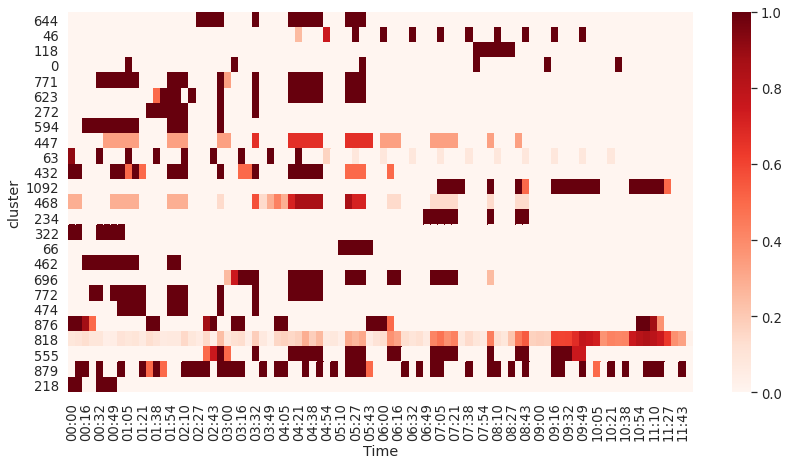

In [74]:
ax = sns.heatmap(series.sample(25), cmap='Reds')
ax.set_xlabel("Time")
ax.set_ylabel("cluster")
ax.set_xticklabels(series.columns.to_series().apply(lambda x: datetime.datetime.strptime(x, '%Y-%m-%d %H:%M').strftime('%H:%M')));
#fig.autofmt_xdate()
#plt.xticks(rotation=0)
plt.yticks(rotation=0)

ax.get_figure().savefig('./data/figures/clusterCentroids.pdf')

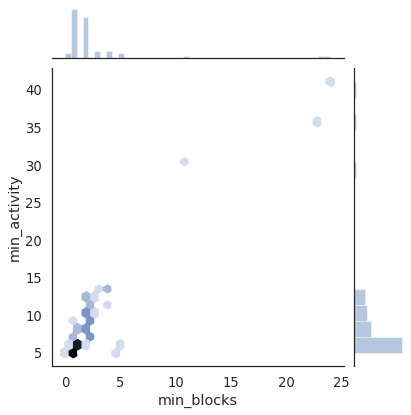

In [61]:

sns.jointplot(data=clusters.loc[top50.index,:], x='min_blocks', y='min_activity', kind='hex')

size       events       tfrom         tto  min_blocks  \
count  993.000000   993.000000  993.000000  993.000000  993.000000   
mean     5.801611    87.081571   28.824773   54.782477    4.344411   
std      6.043852   130.158024   24.962462   25.113111    4.200880   
min      2.000000    15.000000    0.000000    4.000000    0.000000   
25%      3.000000    32.000000    3.000000   35.000000    1.000000   
50%      4.000000    51.000000   25.000000   54.000000    3.000000   
75%      6.000000    92.000000   49.000000   83.000000    6.000000   
max     79.000000  2016.000000   83.000000   87.000000   29.000000   

       min_activity  quality_measure   ip_blocks  
count    993.000000       993.000000  993.000000  
mean      13.595166         0.974581         inf  
std        9.887842         0.044881         NaN  
min        5.000000         0.807018    0.021739  
25%        7.000000         0.958621    0.333333  
50%       11.000000         1.000000    0.500000  
75%       17.000000         1.000000    1.000000  
max       76.000000         1.000000         inf

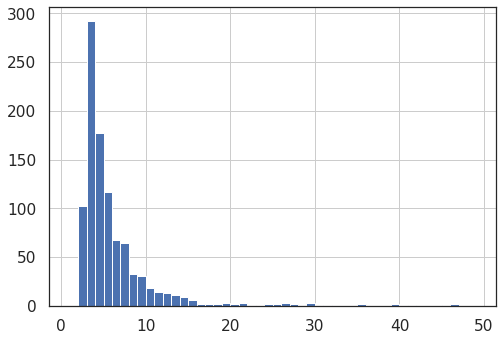

In [13]:
Gclusters['size'].hist(bins=list(range(1,50,1)))
Gclusters.describe()

In [14]:
clusters.loc[:,'ips'].apply(len).sum()




6944

In [15]:
display(clusters.loc[(clusters['size']>6)&(clusters.quality_measure>0.75),:].sort_values(by='size', ascending=False))

ips  \
labels                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                   
313     [39.41.132.172, 2.177.172.52, 81.149.208.127, 117.240.67.97, 111.90.179.139, 116.110.120.219, 117.4.24.21, 27.72.97.176, 103.54.27.28, 183.83.146.1, 223.204.248.53, 14.231.203.99, 177.96.65.149, 200.164.217.212, 178.176.126.78, 109.87.188.212, 117.54.222.18, 222.254.7.200, 179.183.120.248, 123.26.102.45, 201.18.169.186, 189.20.218.229, 82.56.210.18, 37.151.106.178, 66.96.204.156, 27.71.121.67, 180.243.189.158, 103.68.53.254, 183.88.43.209, 37.224.118.49, 14.243.111.80, 115.73.218.193, 62.248.49.14, 190.39.61.158, 123.24.151.184, 201.4.22.148, 180.249.99.255, 177.41.145.85, 85.26.164.149, 189.112.44.88, 36.67.37.23, 202.162.220.8, 122.225.62.94, 91.188.176.150, 201.209.105.80, 94.54.65.14, 113.28.231.5, 152.204.131.6, 118.71.160.1, 123.27.191.29, 64.183.243.226, 171.255.142.189, 217.141.152.162, 62.33.213.18, 115.111.64.42, 14.181.220.136, 95.80.74.110, 125.71.201.50, 177.250.97.234, 41.33.224.196, 31.172.219.53, 131.108.140.14, 92.126.240.30, 186.46.227.157, 115.73.213.60, 103.86.14.50, 14.161.228.107, 24.133.252.189, 116.7.99.43, 118.69.183.3, 180.191.86.89, 118.69.124.184, 95.47.203.193, 14.170.154.50, 5.206.92.255, 101.99.23.105, 188.162.249.167, 95.104.113.118, 190.144.14.30]   
892                                                                                                                                                                                                                                                                                                                                                                                     [45.40.217.249, 150.109.12.157, 148.70.40.41, 162.14.10.158, 162.62.81.212, 45.40.217.90, 119.28.250.108, 175.97.133.109, 45.40.217.22, 162.14.20.83, 162.14.18.106, 162.62.80.182, 162.14.4.53, 119.28.221.116, 162.14.0.163, 162.14.20.182, 162.62.80.88, 123.206.186.69, 162.14.12.143, 203.195.197.140, 54.233.71.187, 45.40.217.99, 45.40.217.224, 119.28.233.223, 129.211.167.207, 45.40.217.146, 45.40.217.89, 47.107.114.157, 150.109.204.252, 162.14.16.6, 162.14.2.214, 162.14.10.227, 162.14.12.107, 162.14.18.54, 162.14.10.94, 103.52.216.156, 162.14.16.142, 162.14.18.167, 162.14.18.180, 162.14.18.146, 45.40.217.166, 162.14.8.67, 162.14.20.174, 162.62.80.193, 35.203.12.124, 140.143.58.55, 162.14.0.46, 47.254.38.145, 162.14.2.91, 162.14.8.254, 162.14.20.162, 49.51.173.222, 45.40.217.229, 58.87.95.83, 162.14.12.152, 162.62.80.111]   
416                                                                                                                                                                                                                                                                                                                                                                        

In [16]:
XX=pd.get_dummies(clusters['grey_tags'].transform(pd.Series))
XX.columns = [x.split('_')[-1] for x in XX.columns]
tmp2 = list(set(XX.columns))
XX = XX.T.groupby(XX.T.index).agg(max).T

import umap
embedding = umap.UMAP(n_components=2).fit_transform(XX)


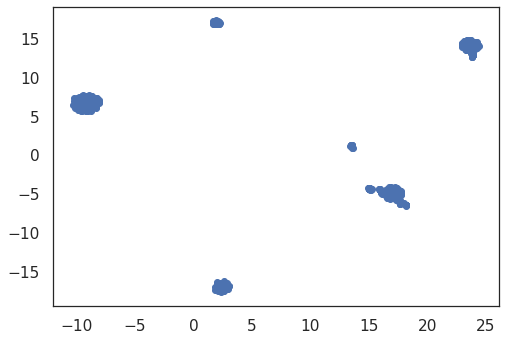

In [17]:
plt.scatter(embedding[:,0], embedding[:,1])

In [18]:
embedding2 = umap.UMAP(n_components=2).fit_transform(series.loc[top50.index,:])
tmp3 = pd.DataFrame(data=embedding2, index=series.loc[top50.index,:].index)
tmp3['class'] = clusters['size'].transform(lambda x: 0 if x < 3 else 1 if x < 7 else 2)
tmp3['blocks'] = clusters['min_blocks'].transform(lambda x: 0 if x < 4 else 1 if x < 17 else 2)


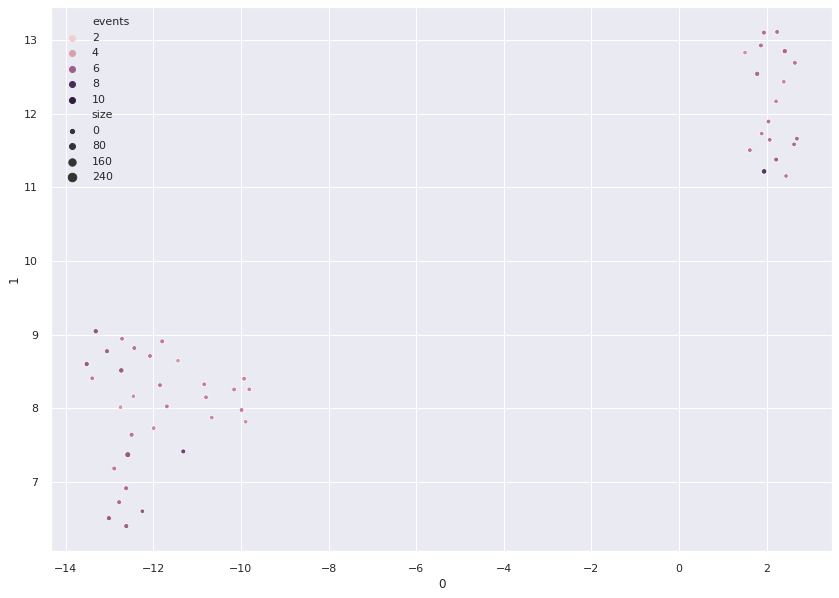

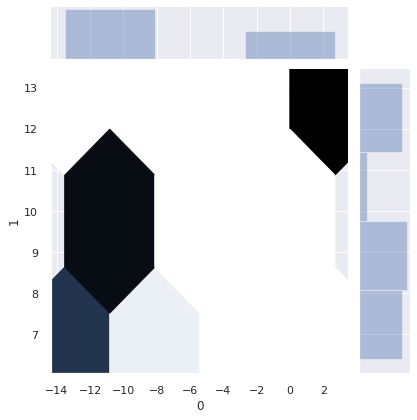

In [19]:
sns.set(rc={'figure.figsize':(14,10)})
sns.scatterplot(data=tmp3, x=0, y=1, hue=np.log(clusters['events']), size=clusters['size'], alpha=1)
sns.jointplot(data=tmp3, x=0,y=1, kind='hex')

In [20]:
groups2 = pd.read_pickle('./data/labels.pcl')
reoccurring = groups2[['occurence','collect']].join(clusters, on='collect')
display(reoccurring.loc[reoccurring.occurence>1,:])

occurence  collect  \
group                       
2              6      892   
0              4      894   
5              4       -1   
8              2       -1   
117            3        0   
...          ...      ...   
45             2       -1   
13             2      482   
91             2       -1   
57             2       -1   
67             6      829   

                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                  ips  \
group                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                   
2      [45.40.217.249, 150.109.12.157, 148.70.40.41, 162.14.10.158, 162.62.81.212, 45.40.217.90, 119.28.250.108, 175.97.133.109, 45.40.217.22, 162.14.20.83, 162.14.18.106, 162.62.80.182, 162.14.4.53, 119.28.221.116, 162.14.0.163, 162.14.20.182, 162.62.80.88, 123.206.186.69, 162.14.12.143, 203.195.197.140, 54.233.71.187, 45.40.217.99, 45.40.217.224, 119.28.233.223, 129.211.167.207, 45.40.217.146, 45.40.217.89, 47.107.114.157, 150.109.204.252, 162.14.16.6, 162.14.2.214, 162.14.10.227, 162.14.12.107, 162.14.18.54, 162.14.10.94, 103.52.216.156, 162.14.16.142, 162.14.18.167, 162.14.18.180, 162.14.18.146, 45.40.217.166, 162.14.8.67, 162.14.20.174, 162.62.80.193, 35.203.12.124, 140.143.58.55, 162.14.0.46, 47.254.38.145, 162.14.2.91, 162.14.8.254, 162.14.20.162, 49.51.173.222, 45.40.217.229, 58.87.95.83, 162.14.12.152, 162.62.80.111]   
0                                                                                                                                                                                                                                                                                                                                                                                                            [107.155.36.2, 14.225.230.51, 211.152.147.21, 58.82.166.166, 203.205.157.49, 211.152.144.95, 128.1.122.18, 23.248.179.21, 47.91.154.29, 169.57.252.62, 107.155.21.91, 3.6.20.252, 23.248.167.3, 211.152.148.106, 45.255.124.207, 150.109.88.30, 119.28.164.101, 42.117.214.21, 203.205.224.43, 128.1.56.47, 211.152.156.58, 170.106.32.101, 45.40.217.136, 23.248.189.24, 119.28.61.53, 23.248.180.139, 150.109.90.105, 211.152.132.23, 118.143.210.166]   
5                                                                                                                                                                                                                                                                        

ips  \
labels                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                   
892     [45.40.217.249, 150.109.12.157, 148.70.40.41, 162.14.10.158, 162.62.81.212, 45.40.217.90, 119.28.250.108, 175.97.133.109, 45.40.217.22, 162.14.20.83, 162.14.18.106, 162.62.80.182, 162.14.4.53, 119.28.221.116, 162.14.0.163, 162.14.20.182, 162.62.80.88, 123.206.186.69, 162.14.12.143, 203.195.197.140, 54.233.71.187, 45.40.217.99, 45.40.217.224, 119.28.233.223, 129.211.167.207, 45.40.217.146, 45.40.217.89, 47.107.114.157, 150.109.204.252, 162.14.16.6, 162.14.2.214, 162.14.10.227, 162.14.12.107, 162.14.18.54, 162.14.10.94, 103.52.216.156, 162.14.16.142, 162.14.18.167, 162.14.18.180, 162.14.18.146, 45.40.217.166, 162.14.8.67, 162.14.20.174, 162.62.80.193, 35.203.12.124, 140.143.58.55, 162.14.0.46, 47.254.38.145, 162.14.2.91, 162.14.8.254, 162.14.20.162, 49.51.173.222, 45.40.217.229, 58.87.95.83, 162.14.12.152, 162.62.80.111]   
894                                                                                                                                                                                                                                                                                                                                                                                                           [107.155.36.2, 14.225.230.51, 211.152.147.21, 58.82.166.166, 203.205.157.49, 211.152.144.95, 128.1.122.18, 23.248.179.21, 47.91.154.29, 169.57.252.62, 107.155.21.91, 3.6.20.252, 23.248.167.3, 211.152.148.106, 45.255.124.207, 150.109.88.30, 119.28.164.101, 42.117.214.21, 203.205.224.43, 128.1.56.47, 211.152.156.58, 170.106.32.101, 45.40.217.136, 23.248.189.24, 119.28.61.53, 23.248.180.139, 150.109.90.105, 211.152.132.23, 118.143.210.166]   
0                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                            [199.101.116.151, 199.101.116.147, 199.101.116.171, 199.101.116.159, 199.101.116.158, 199.101.116.145, 199.101.116.155, 199.101.116.150, 199.101.116.175]   
839                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                              

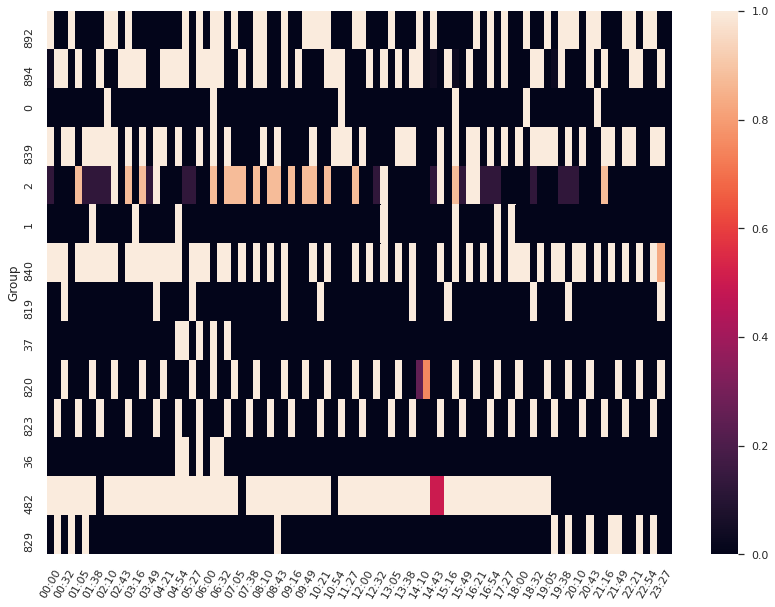

In [21]:
#clusters.loc[groups2.loc[groups2['occurence']>1, 'collect'],:]
fig = plt.figure()
ax=sns.heatmap(series.loc[reoccurring.loc[(reoccurring.occurence>1)&(reoccurring.collect>-1),'collect'], :])
#ax.set_xlabel("Interval")
ax.set_ylabel("Group")
ax.set_xticklabels(series.columns.to_series().apply(lambda x: datetime.datetime.strptime(x, '%Y-%m-%d %H:%M').strftime('%H:%M'))[0::2], rotation = 60);

#ax.get_figure().savefig('./data/figures/ReocurringActivityHeatmap.pdf')

display(clusters.loc[reoccurring.loc[(reoccurring.occurence>1)&(reoccurring.collect>-1),'collect'],:])

In [22]:
#intervals = utils.sample_intervals(series.loc[reoccurring.index,:], '2020-04-17', 900)
#dfflows = clusters_get_flows(reoccurring, intervals)


In [23]:
clusters = clusters.assign(reoccurring = groups2.loc[groups2['collect']>0, 'occurence'].fillna(1))

ips  \
labels                                                                                                                                                                                     
0                              [199.101.116.151, 199.101.116.147, 199.101.116.171, 199.101.116.159, 199.101.116.158, 199.101.116.145, 199.101.116.155, 199.101.116.150, 199.101.116.175]   
1                                                                              [66.151.55.116, 66.151.55.112, 66.151.55.114, 66.151.55.110, 66.151.55.113, 66.151.55.119, 66.151.55.117]   
2                                                                       [64.94.179.10, 64.94.179.36, 64.94.179.44, 64.94.179.60, 64.94.179.12, 141.98.81.108, 64.94.179.28, 64.94.179.8]   
3                                                                                                                                          [36.110.44.187, 124.65.250.102, 39.155.222.2]   
4                                                                                                                                                        [58.133.232.240, 223.71.128.75]   
...                                                                                                                                                                                  ...   
195                                                                                        [196.219.85.212, 180.243.128.35, 186.26.131.238, 42.118.115.193, 116.99.38.27, 93.81.223.223]   
196     [47.31.64.37, 202.88.155.50, 14.250.128.147, 103.74.192.123, 123.160.44.248, 45.141.84.25, 81.10.6.90, 27.56.63.5, 88.234.186.236, 213.14.179.165, 14.185.50.253, 93.81.210.129]   
197                                                                          [49.230.4.76, 111.229.148.31, 177.85.7.122, 14.162.131.204, 125.230.72.162, 141.136.89.244, 182.185.162.41]   
198                                                                                       [211.75.181.195, 185.208.226.116, 103.227.242.6, 35.189.121.94, 180.129.85.174, 61.90.160.216]   
199                         [156.223.188.141, 109.191.12.244, 91.225.200.58, 36.63.181.249, 110.169.223.2, 134.175.151.123, 41.38.235.79, 58.10.227.22, 156.214.245.234, 175.211.171.46]   

        size  events  tfrom   tto  \
labels                              
0          9      54    8.0  77.0   
1          7      49    6.0  65.0   
2          8     210    0.0  78.0   
3          3      33    0.0  77.0   
4          2      20    0.0  77.0   
...      ...     ...    ...   ...   
195        6      36   50.0  59.0   
196       12     112   44.0  49.0   
197        7      51   48.0  53.0   
198        6      57   44.0  48.0   
199       10      62   48.0  52.0   

                                                      types  \
labels                                                        
0                                          {Recon.Scanning}   
1                                          {Recon.Scanning}   
2                      {Attempt.Login,Test, Recon.Scanning}   
3                                          {Recon.Scanning}   
4                                          {Recon.Scanning}   
...                                                     ...   
195                                        {Recon.Scanning}   
196     {Attempt.Login,Test, Attempt.Login, Recon.Scanning}   
197                                        {Recon.Scanning}   
198                    {Attempt.Login,Test, Recon.Scanning}   
199                    {Attempt.Login,Test, Recon.Scanning}   

                                                                                  origins  \
labels                                                                                      
0                                                                      {cz.cesnet.tarpit}   
1                                                                      {cz.cesnet.tarpit}   
2                                      {cz.cesnet.tarpit, cz.c

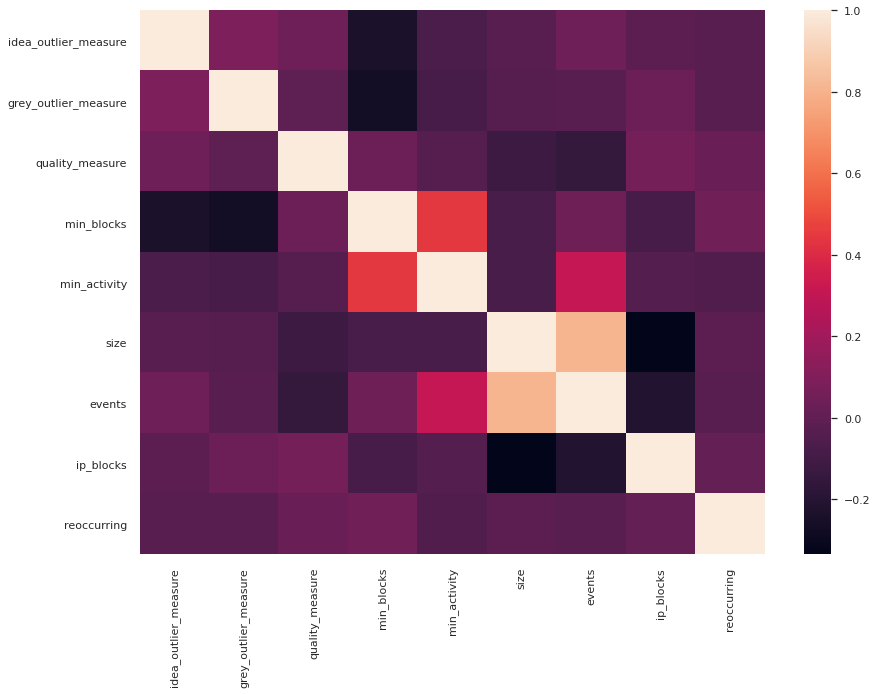

In [24]:

display(clusters.head(200))

columns=['idea_outlier_measure', 'grey_outlier_measure', 'quality_measure', 'min_blocks', 'min_activity', 'size', 'events', 'ip_blocks', 'reoccurring']

sns.heatmap(clusters[columns].fillna(0).corr())


In [25]:
#clusters[columns].describe()

#rows=pd.DataFrame
#rows=pd.concat[]

In [26]:
columns=['idea_outlier_measure', 'grey_outlier_measure', 'quality_measure', 'ip_blocks', 'reoccurring']#'min_blocks', 'min_activity', 'size', 'events', 'ip_blocks', 'reoccurring']

#smpl = pd.DataFrame()
#X = clusters.loc[]
#for name in columns:
#    X = clusters.sort_values(by=name, ascending=False).head(10)
#    X = X.sort_values(by=['size','min_blocks','min_activity'], ascending=False).sample(2)
#    smpl = pd.concat([X, smpl])

In [27]:
#smpl

In [28]:
#lst=[]
#for x in range(16,23):
#groups2 = pd.read_pickle(f'./data/labels22.pcl')
#reoccurring = clusters.join(groups2, right='collect')
#reoccurring=groups2.join(clusters, on='collect', rsuffix='_')

    #display(reoccurring[['size','events','min_activity','tags','grey_tags']])#.to_latex())

In [29]:
#combo = pd.concat([combo3.T, reoccurring.apply(lambda x: x.tags+(x.grey_tags if x.grey_tags is not np.nan else []), axis=1)])

In [30]:
#combo3,combo2

In [31]:
#combo16 = combo1

In [32]:
#combo22=reoccurring.apply(lambda x: x.tags+(x.grey_tags if x.grey_tags is not np.nan else []), axis=1)

In [33]:
#combo=pd.DataFrame(data=[combo16,combo17,combo18,combo19,combo20,combo21,combo22])#, columns=['2020-04-16','2020-04-17','2020-04-18','2020-04-19','2020-04-20','2020-04-21','2020-04-22'])

In [34]:
#combo=combo.T
#combo.columns = ['2020-04-16','2020-04-17','2020-04-18','2020-04-19','2020-04-20','2020-04-21','2020-04-22']

In [246]:
g_data_loc='./data/hdbscan10/groups'
g_analysis_date='2020-04-16_2020-04-22' #starts at beginning of day, ends at the end
g_freq = '1D'

g_path=f"{g_data_loc}/{g_analysis_date}_{g_freq}/"

#load data 
dfdict2 = utils.load_named_df(g_path, ['groups','series'])
groups2=dfdict2['groups']
gseries=dfdict2['series']

lst = []

days = pd.date_range(g_analysis_date.split('_')[0],g_analysis_date.split('_')[-1])

for day in days:
    
    groups2['collect'] = groups2.apply(lambda x: dict(zip(x.intervals,x.labels)).get(pd.to_datetime(day), -1), axis=1)
    
    dt_from, dt_to, dirname = date_input(day.strftime('%Y-%m-%d'))
    path=data_loc+dirname+'/'

    dfdict = utils.load_named_df(path, ['clusters','series'])
    
    clusters=dfdict['clusters']
    series=dfdict['series']
    
    #reoccurring = clusters.join(groups2, right='collect')
    tmp = (groups2.loc[groups2.collect>-1,:].join(clusters, on='collect', rsuffix='_'))
    #display(tmp[['labels','collect','grey_tags']])
    #lst.append(tmp.apply(lambda x: utils.list_list_tolist([x[c] if x[c] is not np.nan else [] for c in ["tags_", "grey_tags"]]) if reoccurring is not -1 else [], axis=1))
    lst.append(tmp.apply(lambda x: utils.list_list_tolist([x[c] if x[c] is not np.nan else [] for c in ["tags", "grey_tags_","nerd_tags_"]]), axis=1))
    #lst2.append(tmp.grey_outlier_measure)
    

    
combo=pd.DataFrame(data=lst).T #, columns=['2020-04-16','2020-04-17','2020-04-18','2020-04-19','2020-04-20','2020-04-21','2020-04-22'])
combo.columns = list([day.strftime('%Y-%m-%d') for day in days])

#combo2=pd.DataFrame(data=lst2).T#, columns=['2020-04-16','2020-04-17','2020-04-18','2020-04-19','2020-04-20','2020-04-21','2020-04-22'])
#combo2.columns = [f"2020-04-{x}" for x in range(16,23)] 


labels  collect  \
group                                                       
44       [1716, 1137, 75, 942, 1257, 1398, 1835]     1716   
1      [1449, 1125, 646, 1058, 1209, 1245, 1728]     1449   
30        [813, 355, 840, 688, 1221, 1278, 1981]      813   
10     [1628, 1190, 708, 1038, 1457, 1414, 1673]     1628   
39      [1761, 1071, 900, 907, 1385, 1463, 1717]     1761   
...                                          ...      ...   
4648                                       [938]      938   
4647                                       [994]      994   
4646                                      [1138]     1138   
2025                                      [1332]     1332   
5559                                       [438]      438   

                                                grey_tags  
group                                                      
44                                                     []  
1                                                      []  
30                                                     []  
10                                                     []  
39                                                     []  
...                                                   ...  
4648                                        [SMB Scanner]  
4647                [SMB Scanner, Looks Like EternalBlue]  
4646                           [SMB Scanner, Eternalblue]  
2025   [SMB Scanner, Eternalblue, Looks Like EternalBlue]  
5559                [SMB Scanner, Looks Like EternalBlue]  

[973 rows x 3 columns]

labels  collect  \
group                                                       
44       [1716, 1137, 75, 942, 1257, 1398, 1835]     1137   
1      [1449, 1125, 646, 1058, 1209, 1245, 1728]     1125   
30        [813, 355, 840, 688, 1221, 1278, 1981]      355   
10     [1628, 1190, 708, 1038, 1457, 1414, 1673]     1190   
39      [1761, 1071, 900, 907, 1385, 1463, 1717]     1071   
...                                          ...      ...   
1891                                       [722]      722   
1825                                       [631]      631   
1814                                       [206]      206   
1839                                       [397]      397   
1935                                       [902]      902   

                        grey_tags  
group                              
44                             []  
1                              []  
30                             []  
10                             []  
39                             []  
...                           ...  
1891                [SMB Scanner]  
1825            [SSH Bruteforcer]  
1814   [SMB Scanner, Eternalblue]  
1839               [SMTP Scanner]  
1935                           []  

[761 rows x 3 columns]

labels  collect  \
group                                                       
44       [1716, 1137, 75, 942, 1257, 1398, 1835]       75   
1      [1449, 1125, 646, 1058, 1209, 1245, 1728]      646   
30        [813, 355, 840, 688, 1221, 1278, 1981]      840   
10     [1628, 1190, 708, 1038, 1457, 1414, 1673]      708   
39      [1761, 1071, 900, 907, 1385, 1463, 1717]      900   
...                                          ...      ...   
1892                                       [955]      955   
1820                                        [48]       48   
1961                                       [205]      205   
1938                                       [966]      966   
1922                                       [220]      220   

                                                grey_tags  
group                                                      
44                                                     []  
1                                                      []  
30                                                     []  
10                                                     []  
39                                                     []  
...                                                   ...  
1892                       [SSH Scanner, SSH Bruteforcer]  
1820   [SMB Scanner, Eternalblue, Looks Like EternalBlue]  
1961   [SMB Scanner, Eternalblue, Looks Like EternalBlue]  
1938                                                   []  
1922                           [SMB Scanner, Eternalblue]  

[614 rows x 3 columns]

labels  collect  \
group                                                       
44       [1716, 1137, 75, 942, 1257, 1398, 1835]      942   
1      [1449, 1125, 646, 1058, 1209, 1245, 1728]     1058   
30        [813, 355, 840, 688, 1221, 1278, 1981]      688   
10     [1628, 1190, 708, 1038, 1457, 1414, 1673]     1038   
39      [1761, 1071, 900, 907, 1385, 1463, 1717]      907   
...                                          ...      ...   
1946                                      [1004]     1004   
1975                                      [1193]     1193   
1965                                       [842]      842   
1930                                       [763]      763   
1928                                       [909]      909   

                                                grey_tags  
group                                                      
44                                                     []  
1                                                      []  
30                                                     []  
10                                                     []  
39                                                     []  
...                                                   ...  
1946                           [SMB Scanner, Eternalblue]  
1975                           [SMB Scanner, Eternalblue]  
1965                                                   []  
1930                                        [SSH Scanner]  
1928   [SMB Scanner, Eternalblue, Looks Like EternalBlue]  

[724 rows x 3 columns]

labels  collect  \
group                                                       
44       [1716, 1137, 75, 942, 1257, 1398, 1835]     1257   
1      [1449, 1125, 646, 1058, 1209, 1245, 1728]     1209   
30        [813, 355, 840, 688, 1221, 1278, 1981]     1221   
10     [1628, 1190, 708, 1038, 1457, 1414, 1673]     1457   
39      [1761, 1071, 900, 907, 1385, 1463, 1717]     1385   
...                                          ...      ...   
1929                                       [144]      144   
1927                                       [839]      839   
1921                                       [716]      716   
1920                                       [717]      717   
1919                                       [721]      721   

                                                grey_tags  
group                                                      
44                                                     []  
1                                                      []  
30                                                     []  
10                                                     []  
39                                                     []  
...                                                   ...  
1929   [SMB Scanner, Eternalblue, Looks Like EternalBlue]  
1927                           [SMB Scanner, Eternalblue]  
1921                           [SMB Scanner, Eternalblue]  
1920                           [SMB Scanner, Eternalblue]  
1919                       [SSH Scanner, SSH Bruteforcer]  

[848 rows x 3 columns]

labels  collect  \
group                                                       
44       [1716, 1137, 75, 942, 1257, 1398, 1835]     1398   
1      [1449, 1125, 646, 1058, 1209, 1245, 1728]     1245   
30        [813, 355, 840, 688, 1221, 1278, 1981]     1278   
10     [1628, 1190, 708, 1038, 1457, 1414, 1673]     1414   
39      [1761, 1071, 900, 907, 1385, 1463, 1717]     1463   
...                                          ...      ...   
1936                                       [519]      519   
1918                                      [1163]     1163   
1934                                      [1317]     1317   
1925                                      [1271]     1271   
1923                                      [1436]     1436   

                                                grey_tags  
group                                                      
44                                                     []  
1                                                      []  
30                                                     []  
10                                                     []  
39                                                     []  
...                                                   ...  
1936   [SMB Scanner, Eternalblue, Looks Like EternalBlue]  
1918                           [SMB Scanner, Eternalblue]  
1934                                        [SMB Scanner]  
1925                           [SMB Scanner, Eternalblue]  
1923                                        [SMB Scanner]  

[830 rows x 3 columns]

labels  collect  \
group                                                       
44       [1716, 1137, 75, 942, 1257, 1398, 1835]     1835   
1      [1449, 1125, 646, 1058, 1209, 1245, 1728]     1728   
30        [813, 355, 840, 688, 1221, 1278, 1981]     1981   
10     [1628, 1190, 708, 1038, 1457, 1414, 1673]     1673   
39      [1761, 1071, 900, 907, 1385, 1463, 1717]     1717   
...                                          ...      ...   
1894                                        [79]       79   
1953                                        [28]       28   
1974                                       [791]      791   
1926                                        [51]       51   
1924                                        [53]       53   

                                                grey_tags  
group                                                      
44                                                     []  
1                                                      []  
30                                                     []  
10                                                     []  
39                                                     []  
...                                                   ...  
1894                                        [SMB Scanner]  
1953   [SMB Scanner, Eternalblue, Looks Like EternalBlue]  
1974                                                   []  
1926                           [SMB Scanner, Eternalblue]  
1924                           [SMB Scanner, Eternalblue]  

[996 rows x 3 columns]

In [241]:
with pd.option_context('display.max_rows', None):
    display(groups2.join(combo).loc[groups2.occurence>1, utils.list_list_tolist([['ips'], combo.columns])])

ips  \
group                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                              
44                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                              [95.213.177.126, 95.213.177.123, 95.213.177.124, 95.213.177.125]   
1      [104.41.9.60, 150.109.12.157, 162.14.2.60, 162.14.8.62, 35.198.115.127, 45.40.217.93, 128.108.1.159, 129.28.160.40, 162.14.0.87, 162.62.81.17, 34.92.195.188, 35.199.29.44, 45.40.217.94, 162.14.8.44, 34.95.209.203, 45.40.217.90, 49.51.195.231, 162.14.10.227, 45.113.68.12, 162.62.80.182, 54.215.215.73, 15.185.66.47, 162.14.20.83, 186.250.154.174, 58.87.95.83, 45.40.217.138, 129.211.167.207, 162.14.20.93, 123.206.186.69, 47.91.92.119, 86.106.31.182, 162.14.10.94, 162.14.10.158, 150.109.183.142, 162.14.18.167, 162.14.0.163, 162.14.16.6, 45.40.217.146, 162.62.81.209, 150.109.204.252, 203.195.197.140, 47.107.114.157, 45.40.217.224, 162.14.18.54, 162.14.2.91, 45.40.217.22, 45.40.217.229, 162.14.20.162, 162.62.80.111, 148.70.40.41, 35.235.69.93, 175.97.133.109, 162.14.12.107, 162.14.10.212, 162.62.80.88, 162.14.20.174, 162.14.16.142, 162.62.80.28, 45.40.217.99, 45.40.217.166, 103.52.216.156, 162.14.2.214, 54.233.71.187, 45.40.217.249, 162.14.12.152, 35.203.12.124, 119.28.250.108, 45.40.217.89, 162.14.4.53, 162.14.20.182, 162.14.12.143, 162.14.18.146, 162.62.80.193, 119.28.221.116, 49.51.173.222, 47.254.38.145, 130.198.72.171, 140.143.58.55, 119.28.233.223, 162.14.8.67, 162.14.18.106, 162.14.18.180, 162.14.0.46, 162.62.81.212, 162.14.8.254, 35.200

Index(['occurence', 'intervals', 'labels', 'tags', 'origin_tags', 'grey_tags',
       'mentat_tags', 'nerd_tags', 'events', 'min_activity', 'min_blocks',
       'ips', 'quality_measure', 'collect'],
      dtype='object')

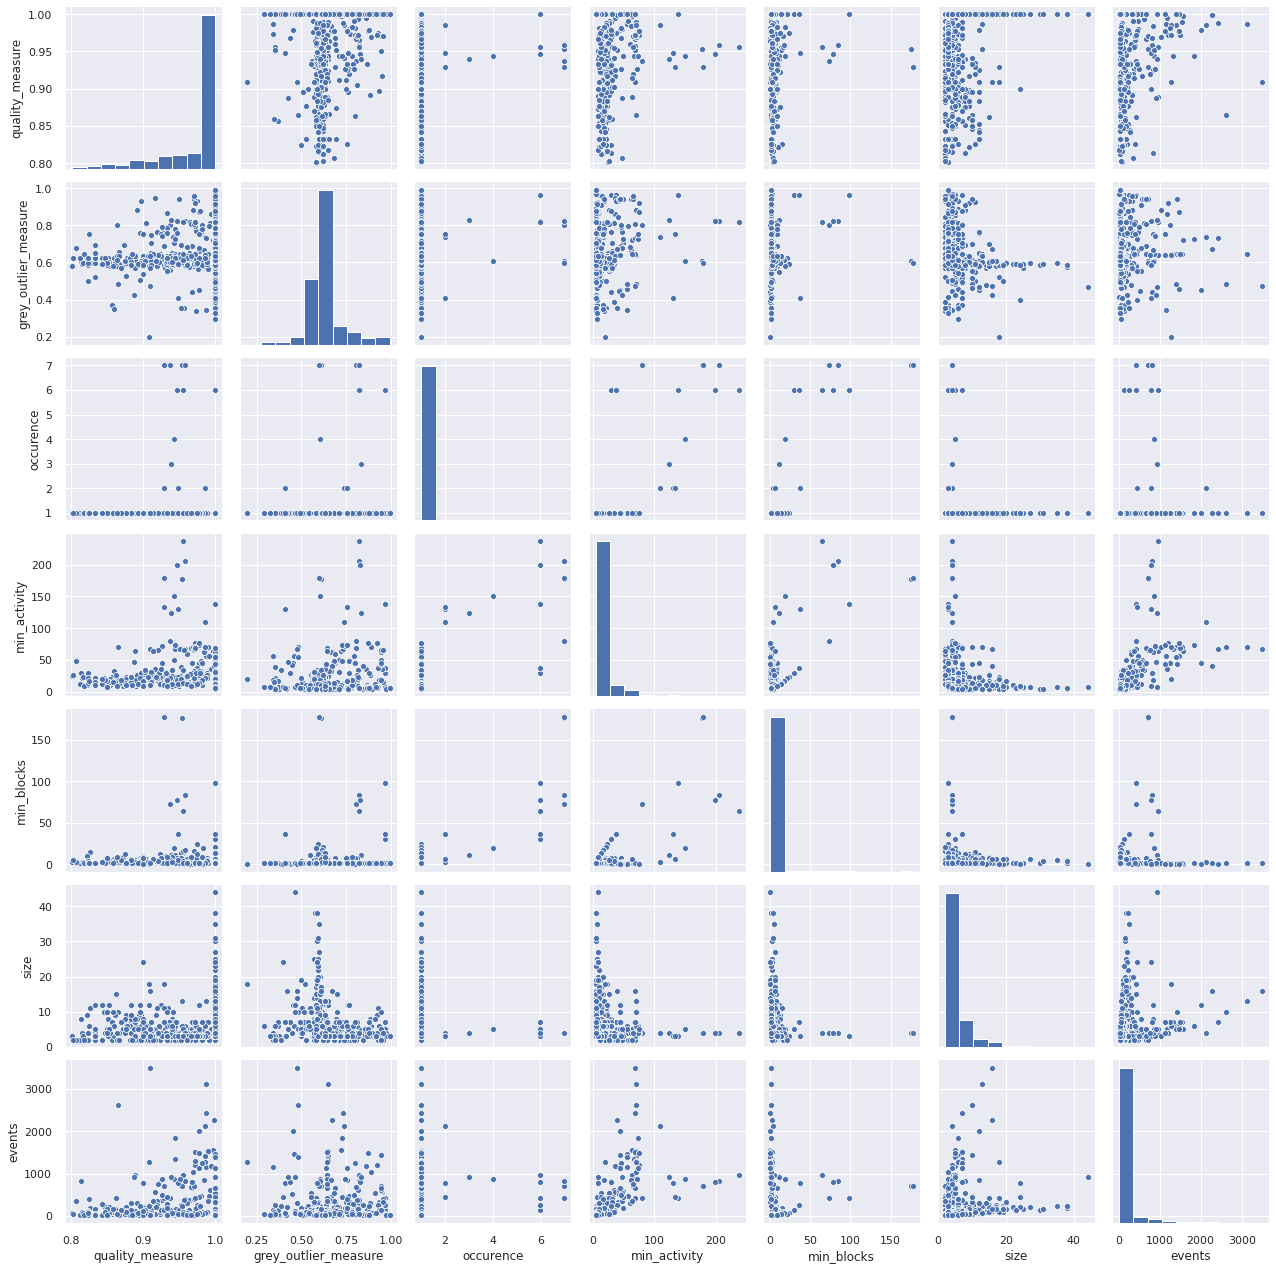

In [78]:
tmp2=tmp
tmp=tmp.loc[tmp.quality_measure>0.8,:]
#sns.heatmap(tmp.loc[tmp['occurence'] > 1,['quality_measure', 'grey_outlier_measure', 'occurence', 'min_activity', 'min_blocks', 'size', 'events']].dropna(how='any').astype(np.float).corr(), cmap='seismic')
#plt.figure()
#sns.heatmap(tmp.loc[tmp['occurence'] <=1,['quality_measure', 'grey_outlier_measure', 'occurence', 'min_activity', 'min_blocks', 'size', 'events']].dropna(how='any').astype(np.float).corr(), cmap='seismic')
#plt.figure()
sns.pairplot(tmp.loc[:,['quality_measure', 'grey_outlier_measure', 'occurence', 'min_activity', 'min_blocks', 'size', 'events']].dropna(how='any').astype(np.float))

In [ ]:
tmp.quality_measure.value_counts()

In [ ]:
sns.heatmap(tmp.loc[tmp['occurence']>0, ['grey_outlier_measure','idea_outlier_measure']].corr())

In [112]:
tmp4=pd.get_dummies(Gclusters[['tags','origin_tags','grey_tags','nerd_tags']].apply(lambda x: pd.Series(utils.list_list_tolist(x)), axis=1), prefix='',prefix_sep='')
tmp4 = tmp4.T.groupby(tmp4.T.index).agg(max).T

with pd.option_context('display.max_rows', None):
    display(tmp4.sum())

Attempt.Login                        48
Attempt.Login,Test                  112
Availability.DoS                      1
Availability.DoS,Test                 2
CHINANET SSH Bruteforcer              1
Eternalblue                         452
Generic Windows Worm                  1
Intrusion.UserCompromise              1
Looks Like EternalBlue              222
MSSQL Bruteforcer                     7
MSSQL Scanner                        20
Memcached Scanner                     1
Mirai                                 3
Ping Scanner                          2
RDP Alternative Port Crawler          1
RDP Scanner                          13
Recon.Scanning                      966
Ruby                                  2
SMB Scanner                         704
SSH Bruteforcer                      68
SSH Scanner                          58
SSH Worm                             30
Squid Proxy Scanner                   1
TLS/SSL Crawler                       6
Telnet Bruteforcer                    2


/home/centos/anaconda3/envs/mlEnv/lib/python3.6/site-packages/seaborn/matrix.py:649: UserWarning:

Clustering large matrix with scipy. Installing `fastcluster` may give better performance.



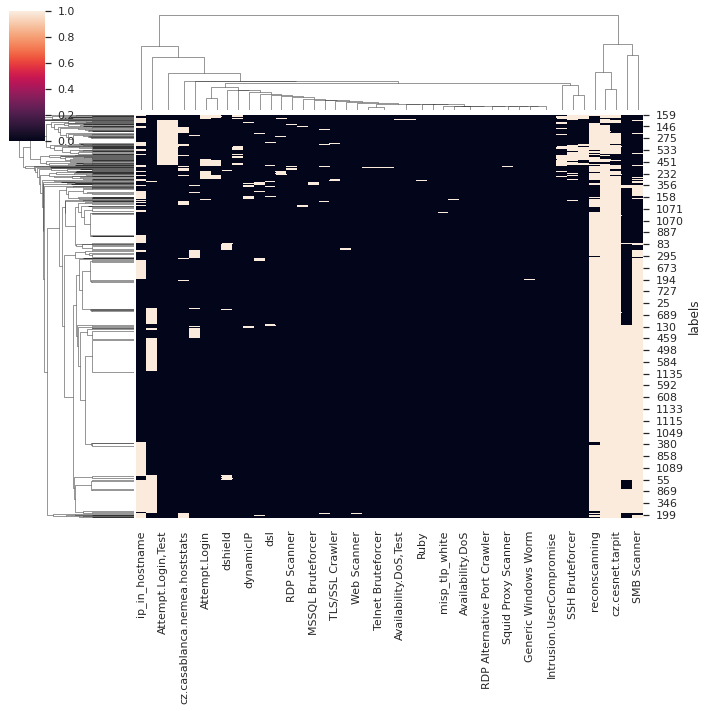

In [102]:
sns.clustermap(tmp4)

In [109]:
#todo select interesing clusters
display(Gclusters.loc[tmp4['staticIP']>0,:])

ips  \
labels                                                                                                                                                                                                                                                 
208     [119.92.237.225, 203.100.77.60, 14.160.50.154, 113.190.242.243, 125.195.17.116, 110.77.227.24, 113.176.122.10, 92.124.146.203, 14.235.24.101, 116.99.200.93, 184.22.202.147, 14.176.228.138, 121.237.49.153, 223.255.225.68, 116.105.254.98]   
295                          [117.4.11.161, 113.165.125.108, 119.97.236.4, 212.119.233.251, 14.182.153.152, 14.190.37.118, 117.4.120.186, 36.75.242.92, 110.54.250.90, 116.98.179.248, 116.206.40.116, 124.158.94.35, 14.247.46.132, 14.235.118.198]   
328                             [14.251.88.144, 14.250.253.153, 113.186.92.251, 79.16.224.123, 14.244.86.80, 125.25.106.155, 157.44.150.243, 5.238.6.128, 116.97.210.149, 36.68.192.56, 49.149.106.255, 197.47.187.45, 61.80.185.171, 14.182.242.34]   
251                                                                         [121.241.208.45, 117.7.171.55, 202.162.221.26, 27.71.85.89, 182.168.18.165, 171.96.74.197, 31.180.162.54, 14.177.236.73, 153.174.141.252, 14.190.244.251, 14.141.73.182]   
227                                                                                           [116.103.218.81, 47.247.39.15, 113.160.102.216, 197.210.45.88, 222.252.30.17, 113.162.39.254, 113.210.95.164, 1.55.55.97, 79.101.33.190, 61.3.187.207]   
...                                                                                                                                                                                                                                              ...   
813                                                                                                                                                                                                                    [219.87.80.3, 14.231.151.235]   
1141                                                                                                                                                                                                                [113.164.236.59, 115.42.204.254]   
775                                                                                                                                                                                                                   [115.78.2.172, 123.16.156.231]   
816                                                                                                                                                                                                                    [186.1.169.23, 14.162.204.77]   
778                                                                                                                                                                                                                 [113.210.181.177, 123.26.224.99]   

        size  events  tfrom   tto                                 types  \
labels                                                                    
208       15      75    5.0   9.0                      {Recon.Scanning}   
295       14      90    4.0   9.0  {Attempt.Login,Test, Recon.Scanning}   
328       14      84   30.0  35.0                      {Recon.Scanning}   
251       11      66   11.0  16.0                      {Recon.Scanning}   
227       10      50   34.0  41.0                      {Recon.Scanning}   
...      ...     ...    ...   ...                                   ...   
813        2      55    3.0  63.0                      {Recon.Scanning}   
1141       2      60   31.0  84.0                      {Recon.Scanning}   
775        2      36    5.0  41.0                      {Recon.Scanning}   
816        2      54    2.0  54.0                      {Recon.Scanning}   
778        2      34    2.0  40.0                      {Recon.Scanning}   

                                        

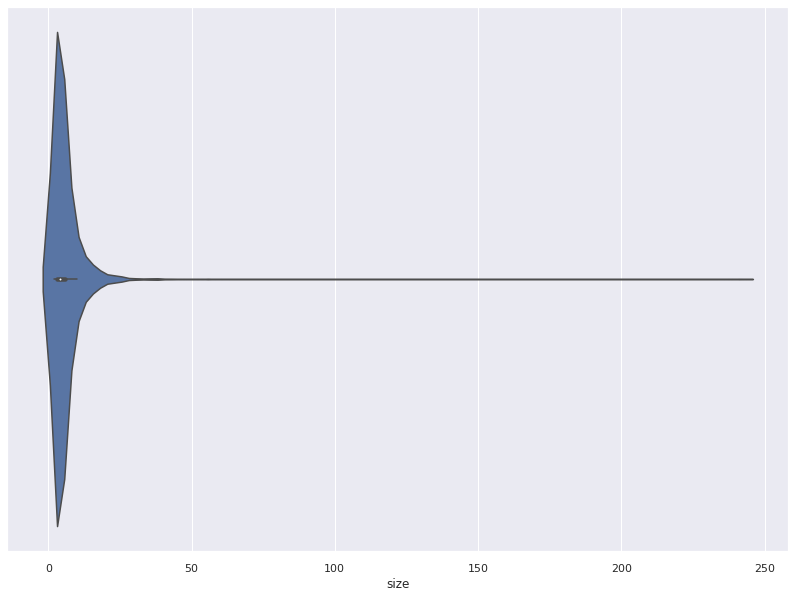

In [117]:
sns.violinplot(clusters[''])

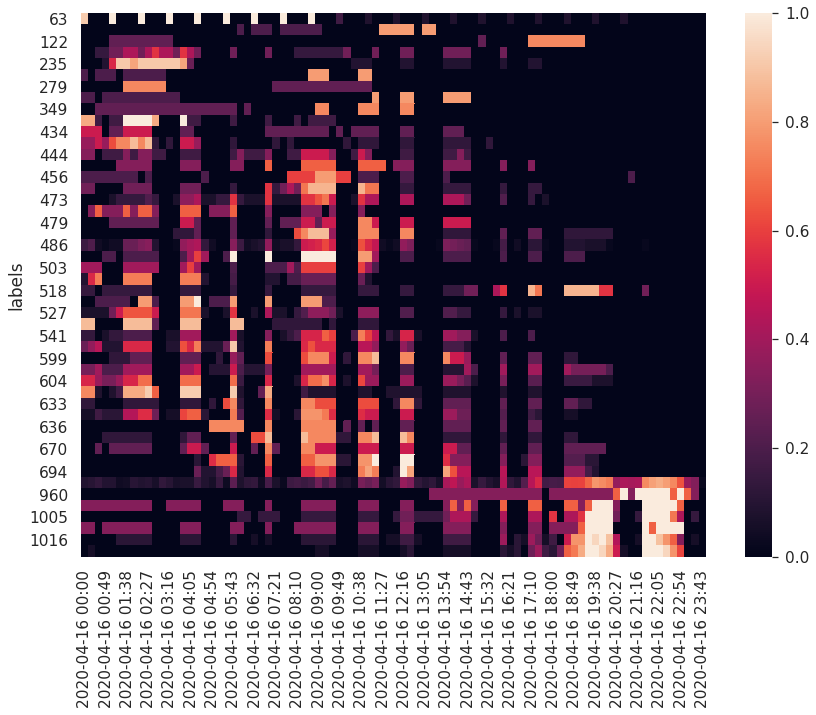

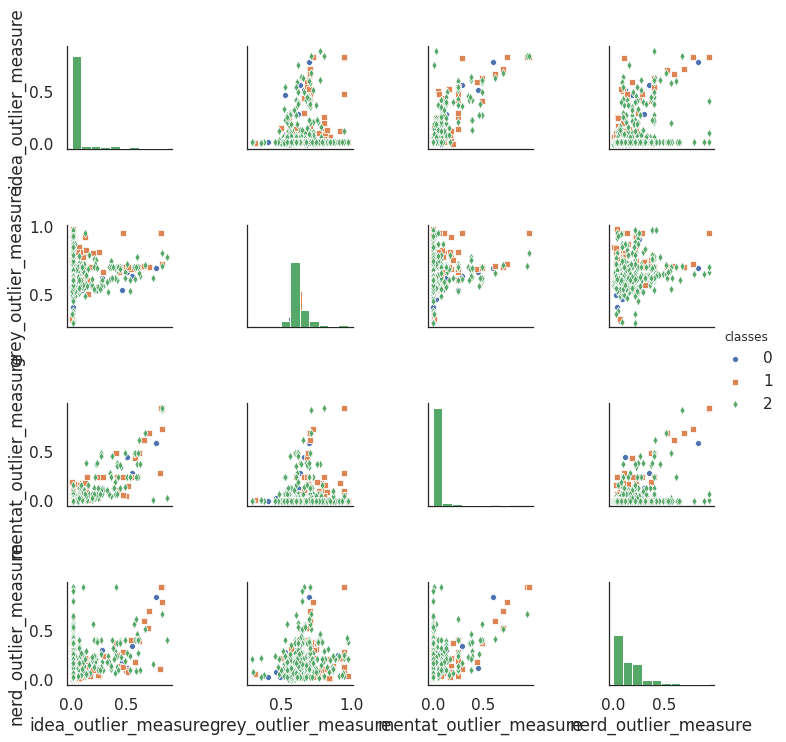

In [229]:
sns.heatmap(series.loc[clusters['quality_measure']<0.5,:])
tmp = clusters.assign(classes=clusters.quality_measure.transform(lambda x: 0 if x < 0.8 else 1 if x < 1 else 2))

display(sns.pairplot(data=tmp[outlier_fields[:]+['classes']], markers=['o','s','d'], hue='classes', diag_kind='hist'))

size                6.075241
events             16.590812
min_activity       13.521435
min_blocks          4.259843
quality_measure     0.922629
outlier_measure     0.613386
dtype: float64

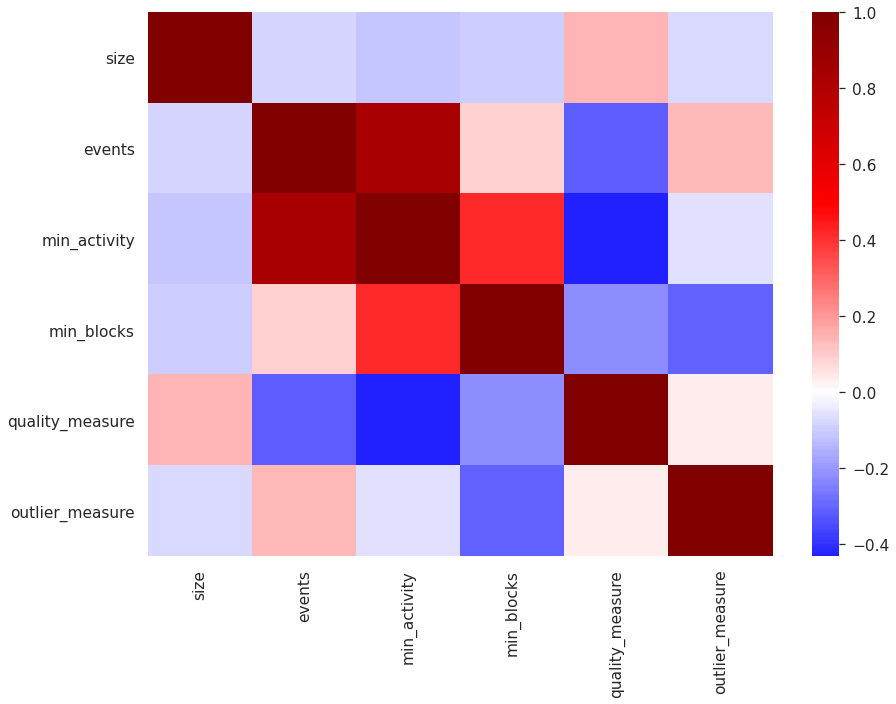

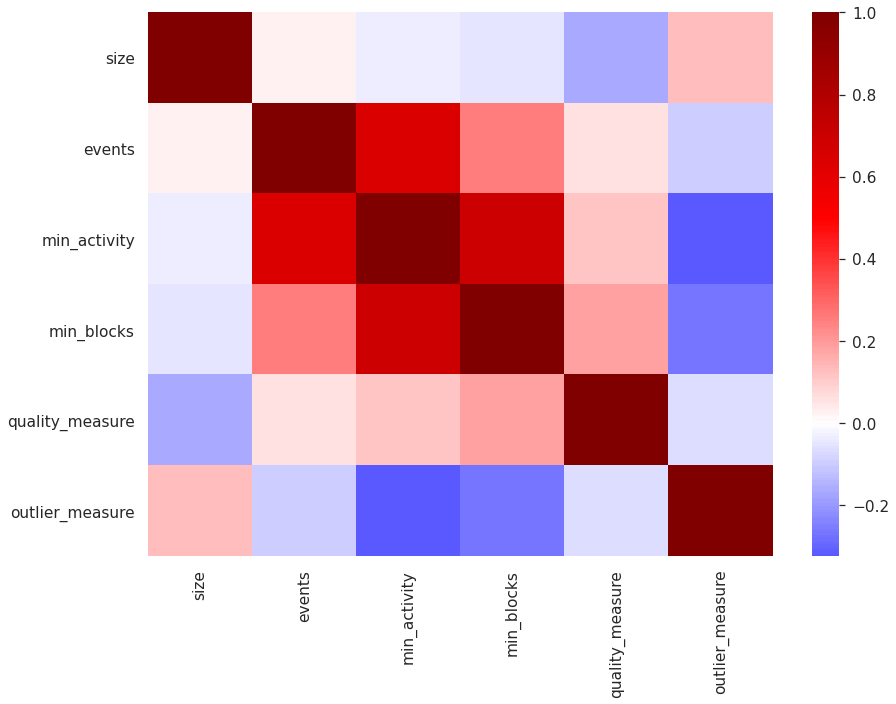

In [210]:
qm = ['size', 'events', 'min_activity', 'min_blocks', 'quality_measure', 'outlier_measure']
outlier_fields = ['idea_outlier_measure', 'grey_outlier_measure', 'mentat_outlier_measure', 'nerd_outlier_measure']
XX = clusters.copy()
XX = XX.assign(events=XX['events']/XX['size'])
XX = XX.assign(outlier_measure=XX[outlier_fields].apply(max, axis=1))
display(XX[qm].mean())

display(sns.heatmap(XX.loc[XX['quality_measure']>=0.9,qm].astype(np.float).corr(), cmap='seismic', center=0))
plt.figure()
display(sns.heatmap(XX.loc[XX['quality_measure'].between(0.75,0.9),qm].astype(np.float).corr(), cmap='seismic', center=0))

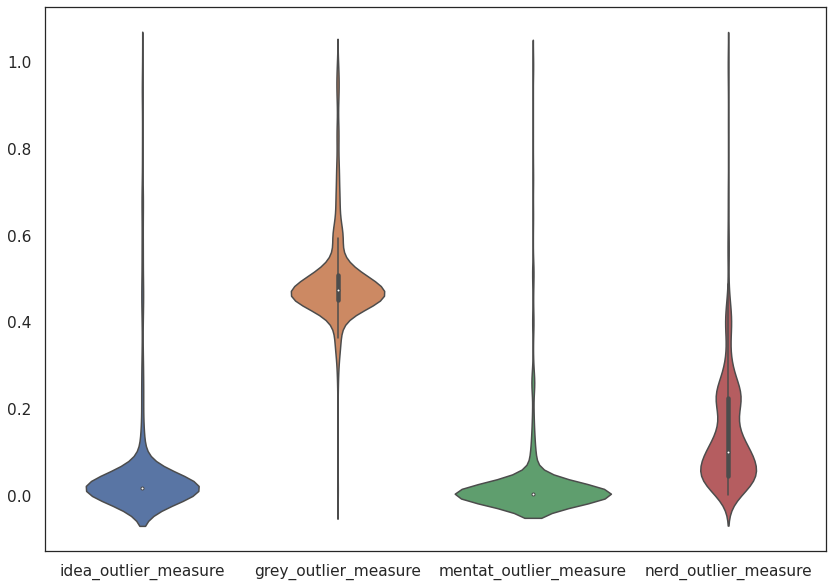

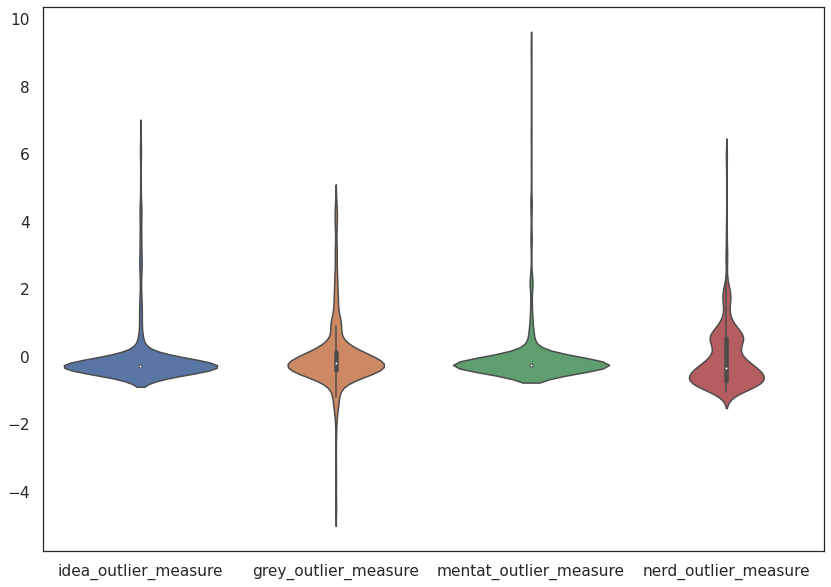

In [188]:
qm=outlier_fields
sns.violinplot(data=(XX[qm]-XX[qm].min())/(XX[qm].max()-XX[qm].min()))
plt.figure()
sns.violinplot(data=(XX[qm]-XX[qm].mean())/(XX[qm].std()))



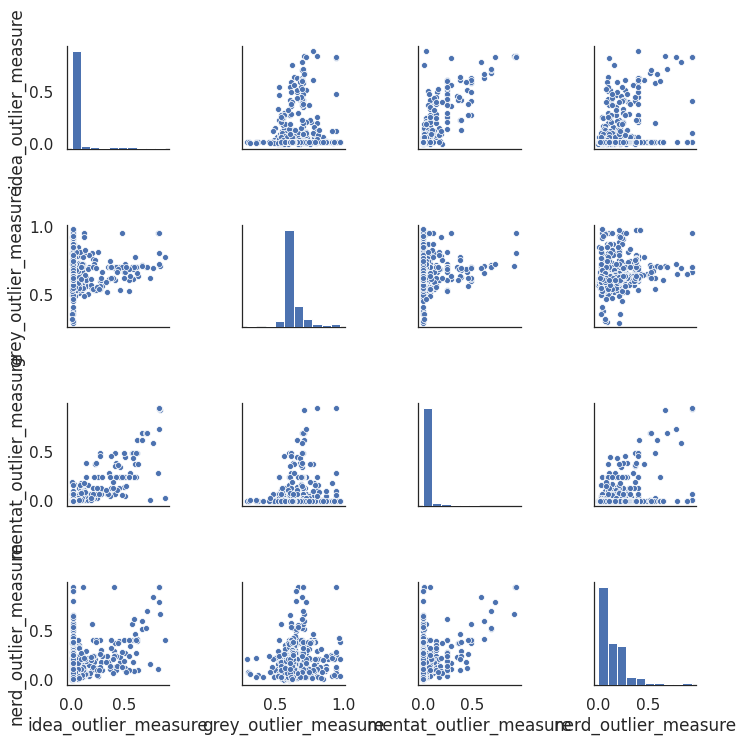

In [190]:
sns.pairplot(data=XX[qm])